### Cell 9. Stellar birth radius as a function of metallicity

#### Purpose

This figure shows the reconstructed stellar birth radius $r_{birth}$ as a function of stellar metallicity $[\mathrm{Fe/H}]$ for `SWEET-Cat` planet-hosting stars. Its purpose is to visualize how chemical composition maps onto Galactic formation radius and to provide a direct physical interpretation of the birth-radius reconstruction.

Unlike the age–metallicity diagram, this figure explicitly links stellar chemistry to Galactic structure and therefore represents the most direct outcome of the adopted Galactic chemical evolution model.

#### Data used

The figure uses reconstructed birth radii obtained with the realistic GCE parameterization and spectroscopic metallicities from SWEET-Cat. Only stars with reliable ages and physically plausible birth radii are included.

#### Method

A scatter plot is constructed with metallicity $[\mathrm{Fe/H}]$ on the x-axis and reconstructed birth radius $r_{birth}$ on the y-axis. Each point represents one planet-hosting star. No binning or smoothing is applied, allowing the intrinsic scatter of the population to be clearly visible.

Saved: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/figures/en/Figure_9.png | size: 79367 bytes


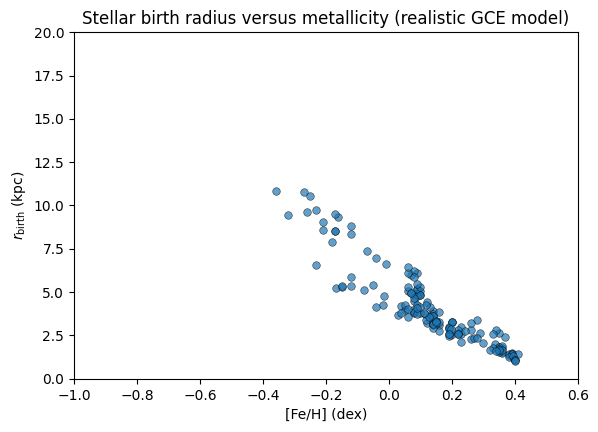

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# --- paths ---
root_path = Path.cwd()
while not (root_path / "topics").exists():
    root_path = root_path.parent

topic_root = root_path / "topics/TOP_0001_exoplanet_birth_radius"
gce_path   = topic_root / "data/processed/sweetcat_rbirth_gce.csv"

# --- load ---
df = pd.read_csv(gce_path)

# --- safety filtering ---
df = df[
    (df["age_gyr"] >= 0.1) &
    (df["age_gyr"] <= 13.5) &
    (df["r_birth_kpc"].notna()) &
    (df["[Fe/H]"].notna())
].copy()

# --- plot ---
fig, ax = plt.subplots(figsize=(6.5, 4.5))

ax.scatter(
    df["[Fe/H]"],
    df["r_birth_kpc"],
    s=30,
    color="tab:blue",
    edgecolors="k",
    linewidths=0.4,
    alpha=0.7
)

ax.set_xlabel(r"[Fe/H] (dex)")
ax.set_ylabel(r"$r_{\rm birth}$ (kpc)")
ax.set_title(r"Stellar birth radius versus metallicity (realistic GCE model)")

ax.set_xlim(-1.0, 0.6)
ax.set_ylim(0, 20)

# --- save ---
save_fig("Figure_9", fig=fig)
plt.show()

*Figure 9. Stellar birth radius as a function of metallicity*

#### Interpretation and conclusions

The diagram reveals a clear overall trend: metal-rich stars preferentially originate from smaller Galactocentric radii, while metal-poor stars tend to have larger birth radii. This behavior directly reflects the negative radial metallicity gradient of the Galactic disk and validates the physical consistency of the reconstruction.

The significant scatter at fixed metallicity highlights the combined effects of time evolution of the ISM, radial migration, and observational uncertainties. Nevertheless, the global correlation demonstrates that metallicity is a strong tracer of stellar birth environment, providing a natural explanation for the observed planet–metallicity relation in a Galactic context.

Although metallicity is physically determined by the Galactic environment at the time and place of star formation, in this work we invert this relation to reconstruct the stellar birth radius from the observed metallicity and age.

### Explanation of the results

Direction of causality vs direction of reconstruction

To avoid confusion between physical causality and methodological reconstruction, it is useful to explicitly distinguish the two directions involved in this analysis.

Galactic structure > ISM metallicity gradient > $[Fe/H](r,t)$ > Star formation > Observed stellar metallicity

Physically, stellar metallicity is determined by the chemical composition of the interstellar medium at the time and place of star formation. In this sense, metallicity is a function of Galactocentric radius and time:

$$ [Fe/H](r,t) = f(r_{birth},t) $$


### Methodological reconstruction (what we do in this work)

Observed $[Fe/H]$ + stellar age> Galactic chemical evolution model > Reconstructed $r_{birth}$

In this work, we invert the physical relation. Using the observed metallicity and the stellar age, together with a model of Galactic chemical evolution, we reconstruct the Galactocentric radius at which such chemical conditions were typical at the time of the star’s formation.

Formally, this corresponds to:

$$ r_{birth} = f^{-1}([Fe/H],age) $$

### Key methodological remark

Metallicity is not treated as a causal variable in this analysis, but as a tracer of the stellar birth environment.

Thus, figures showing $r_{birth}$ as a function of $[\mathrm{Fe/H}]$ should be interpreted as consistency checks and reconstructions, not as statements about physical causality running from metallicity to radius.


### Why this distinction matters

The fact that reconstructed birth radii correlate with metallicity in the expected way provides strong validation of the method. A lack of such correlation would indicate an inconsistency between the reconstruction and the known chemical structure of the Galactic disk.